In [3]:
pip install imblearn

  Using cached scikit_learn-1.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 2.4.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install minisom

Note: you may need to restart the kernel to use updated packages.


In [5]:
# https://github.com/JustGlowing/minisom

In [6]:
# https://tslearn.readthedocs.io/en/stable/index.html

In [7]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [8]:
#! pip install tslearn
#! pip uninstall scikit-learn --yes 
#! pip install scikit-learn==0.24.1

In [9]:
! pip install rfpimp -q

In [10]:
# Native libraries
import os
import math
import warnings

# Essential Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Algorithms
from minisom import MiniSom

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from tqdm.autonotebook import tqdm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold, cross_val_predict
import statsmodels.api as sm
from sklearn.model_selection import StratifiedGroupKFold

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

SEED=23


/tmp/ipykernel_839/4153475966.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [11]:
s_2 = pd.read_csv('3_future_count_complete.csv')
cluster_label = pd.read_csv('4_time_series_clusters_label.csv')
#time_feature_label = pd.read_csv('4_time_weekday_month_clustering.csv')
time_feature_cluster = pd.read_csv('4_time_feature_clustering.csv')
time_high_frequency = pd.read_csv('4_time_highfrequency.csv')
time_feature_cluster_NOT_DUMMY = pd.read_csv('4_time_feature_NOT_DUMMY.csv')

s_2 = s_2.merge(cluster_label, right_on = 'LSOA',left_on = 'LSOA_2011_Name')
#s_2 = s_2.merge(time_feature_label[['KMeans']], left_index = True, right_index = True)
s_2 = s_2.merge(time_high_frequency , left_index = True, right_index = True)
s_2 = s_2.merge(time_feature_cluster_NOT_DUMMY , left_index = True, right_index = True)
s_2 = s_2.drop(columns = ['Unnamed: 0_y'])

In [12]:
s_2

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,index,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
0,0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1,10418,10418,11375,NC11376,15,10/29/2018,2018/19,Burglar/fire alarm,Noise Complaint,...,0,Westminster 018C,1,0,0,1,3,0,1,1
2,2,66,66,68,NC69,6,4/3/2018,2018/19,Burglar/fire alarm,Noise Complaint,...,0,Westminster 018C,2,0,0,1,3,0,1,1
3,3,84,84,90,NC91,20,4/3/2018,2018/19,Busker complaint,Noise Complaint,...,0,Westminster 018C,3,0,0,1,3,0,1,1
4,4,198,198,213,NC214,20,4/6/2018,2018/19,Busker complaint,Noise Complaint,...,0,Westminster 018C,4,0,0,1,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83736,83736,68145,68145,73797,NC73798,1,7/24/2021,2021/22,Residential noise,Noise Complaint,...,0,Westminster 024E,90793,0,0,1,4,4,1,0
83737,83737,68504,68504,74179,NC74180,13,7/30/2021,2021/22,Noise in the street,Noise Complaint,...,0,Westminster 024E,90794,0,0,1,4,4,1,0
83738,83738,68792,68792,74486,NC74487,9,8/4/2021,2021/22,Building site,Noise Complaint,...,0,Westminster 024E,90795,0,0,1,4,4,1,0
83739,83739,74441,74441,80518,NC80519,20,11/1/2021,2021/22,Residential noise,Noise Complaint,...,0,Westminster 024E,90796,0,0,1,4,4,1,0


In [13]:
s_2 = s_2.sort_values(by ='index').set_index('index').loc[0:88298]
s_2


,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [14]:
s_2.to_csv('4_0717_record.csv')

In [15]:
s_2

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [16]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import rfpimp
from imblearn.over_sampling import SMOTE
from pprint import pprint

CPU times: user 39.7 ms, sys: 0 ns, total: 39.7 ms
Wall time: 52.4 ms


# Repeat complaint in next 2 days(today to tomorrow) 

In [17]:
# CV method to Tune the model

In [18]:
#  Defome the shift_dataset
shift_dataset = s_2.copy()

In [19]:
shift_dataset

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [23]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
    
    'LSOA_Encode',
    
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]


independent_columns_minus = [ 
    
    
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]

In [28]:

# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='not majority', random_state=42)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(shift_dataset[independent_columns_minus], shift_dataset['is_repeat_2days'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

# 由于这里多了一个order,但是resampled数据顺序产生变化

In [31]:
oversampled

,is_repeat_2days,Year,Month,Weekday,Season,days,Time,bef_todays_count,bef_yesterday_count,bef_2_7days_count,...,weekday_cl_3,LSOA_Count,Adress_Count,Building Site,Commercial Premises,Email Complaint (1d),Non Noise Complaint (45m),Property Alarm,Residential Premises,Street
0,0,2018,4,6,2,0,0,0,0,0,...,0,1975,2,0,0,0,0,1,0,0
1,0,2018,4,6,2,0,0,0,0,0,...,1,843,1,0,0,0,0,0,1,0
2,0,2018,4,6,2,0,0,0,0,0,...,0,661,7,0,0,0,0,0,1,0
3,0,2018,4,6,2,0,0,0,0,0,...,0,527,5,0,0,0,0,0,1,0
4,0,2018,4,6,2,0,2,0,0,0,...,0,1566,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128461,1,2021,5,3,2,1145,22,1,0,0,...,1,538,66,0,0,0,0,0,1,0
128462,1,2021,4,5,2,1132,16,0,0,1,...,1,434,112,0,0,0,0,0,1,0
128463,1,2021,1,2,1,1014,6,0,0,0,...,0,430,40,0,0,0,0,0,1,0
128464,1,2022,2,5,1,1427,17,0,0,0,...,0,454,5,0,0,0,0,0,0,0


In [81]:
#oversampled =oversampled.merge(shift_dataset[['Unnamed: 0_x','LSOA11CD']], left_on = 'Unnamed: 0_x', right_on = 'Unnamed: 0_x' )


In [26]:


le = LabelEncoder() # creates the LabelEncoder object
le.fit([ 0,1]) # encode '0','1','2' with 0, 1, 2 respectively
# runs LabelEncoder on the accident_count_levelcolumn
label_y = le.transform(oversampled['is_repeat_2days']) # runs LabelEncoder on the accident_count_levelcolumn

In [27]:
shift_dataset_2_dict = oversampled[independent_columns].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(shift_dataset_2_dict).toarray() 
print("Number of variables in this transformed data: {}".format(vec_array.shape[1]))
random_state_split = 1024
index = oversampled.index.values

train_d, test_d, train_lab, test_lab, train_index, test_index = train_test_split(vec_array, label_y, index, random_state=random_state_split)
len(train_d),len(test_d),len(train_lab),len(test_lab),len(train_index),len(test_index)

Number of variables in this transformed data: 34


(96349, 32117, 96349, 32117, 96349, 32117)

In [28]:
# 最佳参数{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}

random_state_RF = 200
forest_clf = RandomForestClassifier(n_estimators =1000, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=True, random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9327133649544884
The accuracy of this classifier on the test data is:0.8923311641809634


# Repeat complaint in next 2 days(today to tomorrow) 

In [92]:
# CV method to Tune the model

In [93]:
#  Defome the shift_dataset
shift_dataset = s_2.copy()

In [94]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
    
    'LSOA_Encode',
    
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]


independent_columns_minus = [ 
    
    
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]

In [95]:
le = LabelEncoder() # creates the LabelEncoder object

shift_dataset['LSOA_Encode'] = le.fit_transform(shift_dataset['LSOA_2011_Code'])

# Resampling the minority class. The strategy can be changed as required.


sm = SMOTE(sampling_strategy='not majority', random_state=42)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(shift_dataset[independent_columns], shift_dataset['is_repeat_2days'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

#oversampled['LSOA_Encode'] = le.inverse_transform(oversampled['LSOA_Encode'])

In [30]:
oversampled

,is_repeat_2days,Year,Month,Weekday,Season,days,Time,bef_todays_count,bef_yesterday_count,bef_2_7days_count,...,weekday_cl_3,LSOA_Count,Adress_Count,Building Site,Commercial Premises,Email Complaint (1d),Non Noise Complaint (45m),Property Alarm,Residential Premises,Street
0,0,2018,4,6,2,0,0,0,0,0,...,0,1975,2,0,0,0,0,1,0,0
1,0,2018,4,6,2,0,0,0,0,0,...,1,843,1,0,0,0,0,0,1,0
2,0,2018,4,6,2,0,0,0,0,0,...,0,661,7,0,0,0,0,0,1,0
3,0,2018,4,6,2,0,0,0,0,0,...,0,527,5,0,0,0,0,0,1,0
4,0,2018,4,6,2,0,2,0,0,0,...,0,1566,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128461,1,2021,5,3,2,1145,22,1,0,0,...,1,538,66,0,0,0,0,0,1,0
128462,1,2021,4,5,2,1132,16,0,0,1,...,1,434,112,0,0,0,0,0,1,0
128463,1,2021,1,2,1,1014,6,0,0,0,...,0,430,40,0,0,0,0,0,1,0
128464,1,2022,2,5,1,1427,17,0,0,0,...,0,454,5,0,0,0,0,0,0,0


In [97]:


le = LabelEncoder() # creates the LabelEncoder object
le.fit([ 0,1]) # encode '0','1','2' with 0, 1, 2 respectively
# runs LabelEncoder on the accident_count_levelcolumn
label_y = le.transform(oversampled['is_repeat_2days']) # runs LabelEncoder on the accident_count_levelcolumn

In [98]:
# Extract indices from oversampled dataset
indices = oversampled.index.values
indices

array([     0,      1,      2, ..., 128463, 128464, 128465])

In [99]:
shift_dataset_2_dict = oversampled[independent_columns_minus].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(shift_dataset_2_dict).toarray() 
print("Number of variables in this transformed data: {}".format(vec_array.shape[1]))
random_state_split = 1024


train_d, test_d, train_lab, test_lab,train_indices,test_indices = train_test_split(vec_array, label_y, indices,random_state=random_state_split)
len(train_indices),len(test_indices)

Number of variables in this transformed data: 34


(96349, 32117)

In [41]:
# 最佳参数'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
random_state_RF = 200
forest_clf = RandomForestClassifier(n_estimators =1000, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=True, random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9337097427062034
The accuracy of this classifier on the test data is:0.8790671606937136


In [42]:


le = LabelEncoder() # creates the LabelEncoder object
le.fit([ 0,1]) # encode '0','1','2' with 0, 1, 2 respectively
# runs LabelEncoder on the accident_count_levelcolumn
label_y = le.transform(oversampled['is_repeat_2days']) # runs LabelEncoder on the accident_count_levelcolumn


shift_dataset_2_dict = oversampled[independent_columns_minus].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(shift_dataset_2_dict).toarray() 
print("Number of variables in this transformed data: {}".format(vec_array.shape[1]))
random_state_split = 1024


train_d, test_d, train_lab, test_lab = train_test_split(vec_array, label_y,random_state=random_state_split)
len(train_d),len(test_d),len( train_lab),len(test_lab)

Number of variables in this transformed data: 34


(96349, 32117, 96349, 32117)

In [43]:
# 最佳参数'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
random_state_RF = 200
forest_clf = RandomForestClassifier(n_estimators =1000, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=True, random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9337097427062034
The accuracy of this classifier on the test data is:0.8790671606937136


In [100]:
# Use rfpimp library to analyse the importance of each feature
# the rfpimp.importances() function only accept train and test data in the form of dataframe

x = pd.DataFrame(test_d)
y = pd.DataFrame(test_lab)
x_columns = vec.get_feature_names()
x.columns = x_columns 

                           Importance
Feature                              
Adress_Count                 0.117570
Residential Premises         0.062366
Street                       0.059190
Commercial Premises          0.040602
Building Site                0.027462
bef_30_365days_count         0.022605
Time                         0.018370
bef_7_30days_count           0.017530
days                         0.016160
bef_365_begindays_count      0.015599
Weekday                      0.015475
bef_2_7days_count            0.014976
year_month_cl_0              0.012237
month_cl_2                   0.010586
LSOA_Count                   0.009808
year_month_cl_1              0.009777
month_cl_1                   0.008220
time_cl_1                    0.008033
Property Alarm               0.007877
year_month_cl_2              0.007006
Month                        0.006632
time_cl_2                    0.006258
month_cl_0                   0.006103
time_cl_0                    0.005947
weekday_cl_3

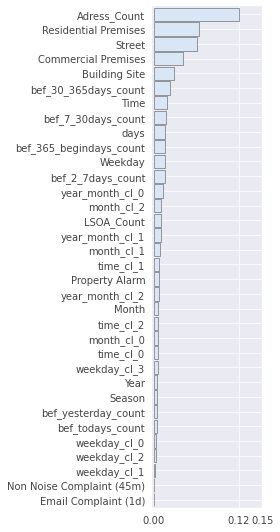

In [101]:
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()